<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #1: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ES models and getting aqcuainted with time series analysis (with python pandas).

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (10%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
     - 3) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep42.csv</span> (105 TS of goods sales in shop #42 of one real Retail Net, each TS correspond to an item in shop)
     - 4) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep6.csv </span>(110 TS of goods sales in shop #6 of one real Retail Net, each TS correspond to an item in shop)
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ1-xS0s6FhP5x-05g'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot time series (for data sets with a lot of TS you need to plot integral sales of all items in shop)
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

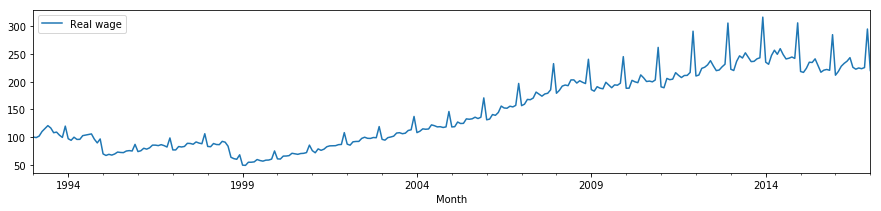

In [222]:
# start with this code
import statsmodels.api as sm
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from utils import qualityRMSE, qualityMedianAE
from utils import ExponentialSmoothing
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv('data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)

# Put your code below
data.plot(figsize=(15,3))

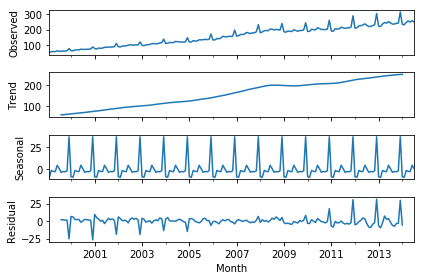

In [224]:
res = sm.tsa.seasonal_decompose(data['Real wage'].ix['1999-02-01 00:00':'2014-07-01 23:00'].resample('M').mean())
resplot = res.plot()

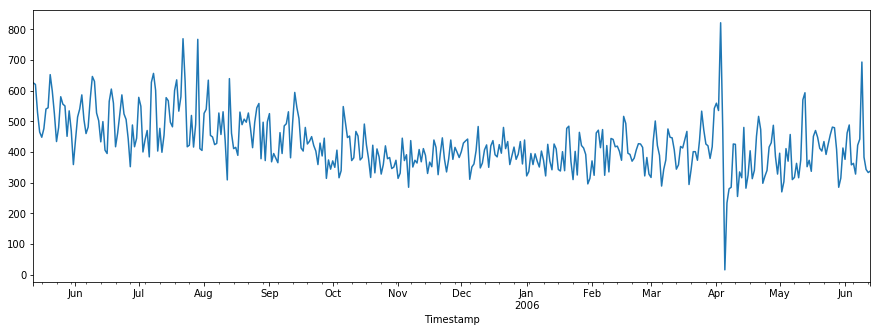

In [226]:
ts36 = pd.read_csv('data\TS_dep36.csv', sep=';', decimal='.', index_col='Timestamp', parse_dates=True, dayfirst=True)

# Put your code below
ts36.sum(axis = 1).plot(figsize=(15,5))
ts36 = ts36.sum(axis = 1)

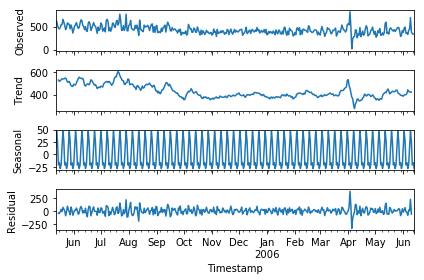

In [227]:
res = sm.tsa.seasonal_decompose(ts36.resample('D').mean())
resplot = res.plot()

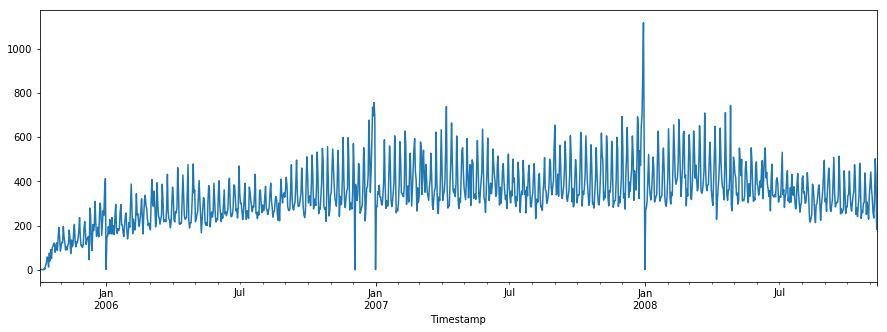

In [228]:
ts42 = pd.read_csv('data\TS_dep42.csv', sep=';', decimal='.', index_col='Timestamp', parse_dates=True, dayfirst=True)

ts42.sum(axis = 1).plot(figsize=(15,5))
ts42 = ts42.sum(axis = 1)

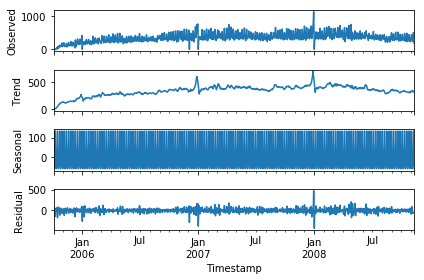

In [229]:
res = sm.tsa.seasonal_decompose(ts42.resample('D').mean())
resplot = res.plot()

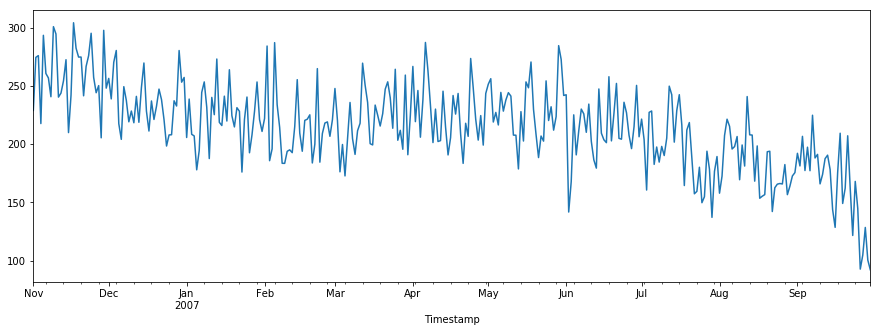

In [230]:
ts6 = pd.read_csv('data\TS_dep6.csv', sep=';', decimal='.', index_col='Timestamp', parse_dates=True, dayfirst=True)

ts6.sum(axis = 1).plot(figsize=(15,5))
ts6 = ts6.sum(axis = 1)

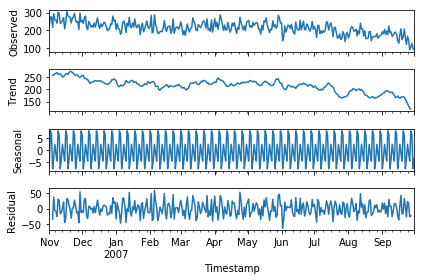

In [231]:
res = sm.tsa.seasonal_decompose(ts6.resample('D').mean())
resplot = res.plot()

<h1 align="center">2. Apply Simple ES to data with trend and Seasonality (15%) </h1>
You need to apply SES (IES see seminar 2) model for TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

 * 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You can choose any loss function from seminar 2).
 * 2) Draw forecast with optimial value $\alpha$ for data from 09.1998 to 01.2017. Conclude whether SES can be used for this TS? If can not than explain why.
 * 3) Calculate accuracy of the forecast of TS in [02.2016, 01.2017].
 * 4) Aggregate original TS by Years (time step chould be 1 year). Repeat point 1)-2) for aggregated TS.

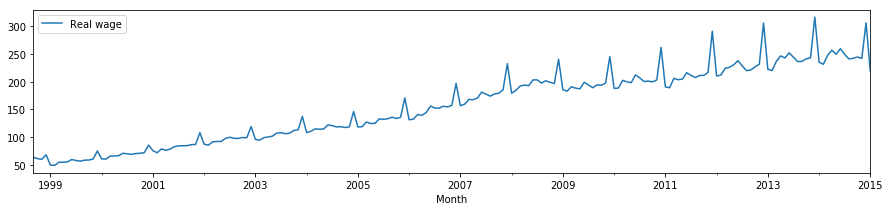

In [190]:
ts = data.ix['1998-09-01':'2015-01-31']
ts.plot(figsize=(15,3))

In [99]:
# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y)**2

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

In [153]:
def SimpleExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*(1-alpha) + alpha*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [154]:
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [209]:
h = 1
ALPHA = [0.01,0.7, 0.4, 0.2, .5, 0.1, 0.3, 0.8, 0.9]
FRC_TS = dict()

for alpha in ALPHA:
    frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                          , columns = ts.columns)
    for cntr in ts.columns:
        frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':alpha})
    FRC_TS['ES alpha %.2f' % alpha] = frc_ts

In [211]:
# compare ES parameters
QualityStr = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality through 1500 steps
ix = range(len(ts.index))
for param_cntr in sorted(QualityStr.columns):
    frc_ts = FRC_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(ts.ix[ix], frc_ts.ix[ix])

(QualityStr)

,ES alpha 0.01,ES alpha 0.20,ES alpha 0.30,ES alpha 0.50,ES alpha 0.90,ES alpha 0.40,ES alpha 0.70,ES alpha 0.80,ES alpha 0.10
Real wage,0.386704,0.06049,0.056851,0.057935,0.061984,0.056676,0.06057,0.061527,0.080397


I have chosen $\alpha = 0.4$ which gave apretty good results, for smaller alpha the prediction was far from the original TS, I have looked for an optimal alpha in the set $\alpha = \{0.1, 0.3, 0,4, 0.01, 0.5, 0.7, 0.8, 0.9\}$. And obvioiusly $\alpha$ closer to 0.3 are the best, so close to 0, but not too close, as we see $\alpha = 0.01$ gives a bad result.

In [157]:
# ES params
Params ={'alpha':0.4}

# forecast
for cntr in ts.columns:
    x = ts[cntr]
    frc_ts[cntr] = SimpleExponentialSmoothing(x, h, Params)

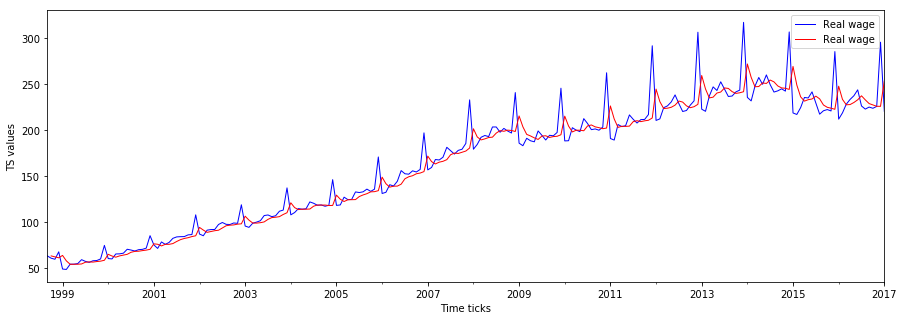

In [158]:
# put your code here


# Example: draw of ts and it's forecast

ax = ts.ix['1998-09-01':'2017-01-30'].plot(style='b', linewidth=1.0,)
frc_ts.ix['1998-09-01':'2017-01-30'].plot(style='r', figsize=(15,5), linewidth=1.0, ax=ax)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
# plt.legend()

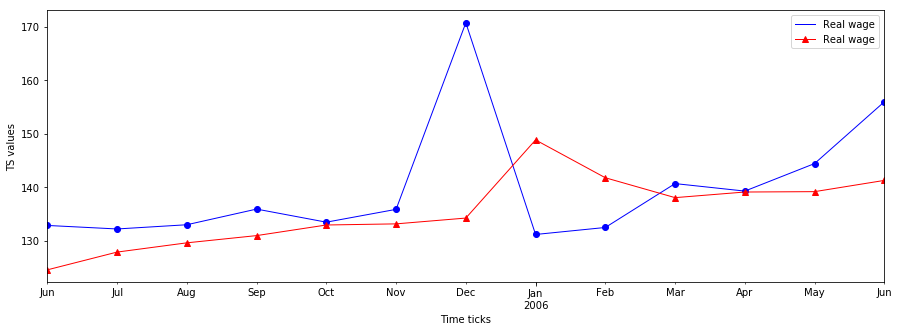

In [159]:
# put your code here


# Look at a smaller interval, to see more clearly

ax = ts.ix['2005-05-12':'2006-06-10'].plot(style='b', linewidth=1.0, marker='o')
frc_ts.ix['2005-05-12':'2006-06-10'].plot(style='r-^', figsize=(15,5), linewidth=1.0, ax=ax)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
# plt.legend()

In [174]:
ix = range(len(ts.index))
qualityMAPE(ts.loc['2015-01-01':]['Real wage'], frc_ts.loc['2015-01-01':]['Real wage'])[0]

0.06879708308707957

<h1 align="center">3. Winters model for Additive Seasonality (25%) </h1>
You need to realize ES model for TS with additive seasonality and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Winters model for Seasonal TS (use code from seminar 2 as example)
* 2) Find optimal params $\alpha$ (smoothing of level) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of SES: is it better? 
* \*5) Conclude whether Winter's ES can be used for this TS?

In [145]:
# Start with this code


###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= x[0]
    s= [0]* (p)
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr] 
 
            if math.isnan(s[cntr % p]):
                s[cntr % p]= s([(cntr-1)%p]) 
            l_old = l
            l = l*(1-alpha) + alpha*(x[cntr]-s[cntr % p])
            s[cntr % p] = (1-delta)*s[cntr % p] + delta *(x[cntr]-l_old)
        
        FORECAST[cntr+h] = l + s[(cntr+h)% p]
    return FORECAST

In [146]:
# Put your code here
ts = data
# Example: run forecast:
h = 1
rng = pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))

w_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
#  Quality = [np.NaN]*len(ts)
for cntr in ts.columns:
    w_frc_ts[cntr] = WintersExponentialSmoothing(ts[cntr], h, {'alpha':0.1, 'delta': 0.5, 'seasonality_period': 12})

In [213]:
ts1 = data.ix['1998-09-01':'2015-01-31']
h = 1
params = [{'alpha':0.1, 'delta': 0.1, 'seasonality_period': 12},
        {'alpha':0.55, 'delta': 0.91, 'seasonality_period': 12},
        {'alpha':0.9, 'delta': 0.1, 'seasonality_period': 12},
        {'alpha':0.1, 'delta': 0.3, 'seasonality_period': 12},
        {'alpha':0.5, 'delta': 0.3, 'seasonality_period': 12},
        {'alpha':0.9, 'delta': 0.3, 'seasonality_period': 12},
        {'alpha':0.1, 'delta': 0.9, 'seasonality_period': 12},
        {'alpha':0.5, 'delta': 0.99, 'seasonality_period': 12},
        {'alpha':0.9, 'delta': 0.9, 'seasonality_period': 12},
        {'alpha':0.1, 'delta': 0.95, 'seasonality_period': 12},
        {'alpha':0.6, 'delta': 0.9, 'seasonality_period': 12},
         {'alpha':0.3, 'delta': 0.7, 'seasonality_period': 12},
         {'alpha':0.35, 'delta': 0.9, 'seasonality_period': 12},
         {'alpha':0.4, 'delta': 0.9, 'seasonality_period': 12},
        {'alpha':0.5, 'delta': 0.95, 'seasonality_period': 12}]

FRC_TS = dict()

for param in params:
    frc_ts = pd.DataFrame(index = ts1.index.append(pd.date_range(ts1.index[-1]+timedelta(1), ts1.index[-1]+timedelta(h)))
                          , columns = ts.columns)
    for cntr in ts.columns:
        frc_ts[cntr] = WintersExponentialSmoothing(ts1[cntr], h, param)
    FRC_TS[str(param)] = frc_ts

# compare ES parameters
QualityStr = pd.DataFrame(index = ts1.columns, columns = FRC_TS.keys())

ix = range(len(ts1.index))

for param_cntr in sorted(QualityStr.columns):
    frc_ts = FRC_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(ts1.iloc[ix], frc_ts.iloc[ix])
QualityStr.T

,Real wage
"{'alpha': 0.5, 'seasonality_period': 12, 'delta': 0.99}",0.026929
"{'alpha': 0.3, 'seasonality_period': 12, 'delta': 0.7}",0.029624
"{'alpha': 0.1, 'seasonality_period': 12, 'delta': 0.9}",0.052912
"{'alpha': 0.1, 'seasonality_period': 12, 'delta': 0.95}",0.052486
"{'alpha': 0.1, 'seasonality_period': 12, 'delta': 0.3}",0.062788
"{'alpha': 0.9, 'seasonality_period': 12, 'delta': 0.9}",0.031033
"{'alpha': 0.5, 'seasonality_period': 12, 'delta': 0.95}",0.026408
"{'alpha': 0.4, 'seasonality_period': 12, 'delta': 0.9}",0.026673
"{'alpha': 0.9, 'seasonality_period': 12, 'delta': 0.3}",0.027083
"{'alpha': 0.6, 'seasonality_period': 12, 'delta': 0.9}",0.026157


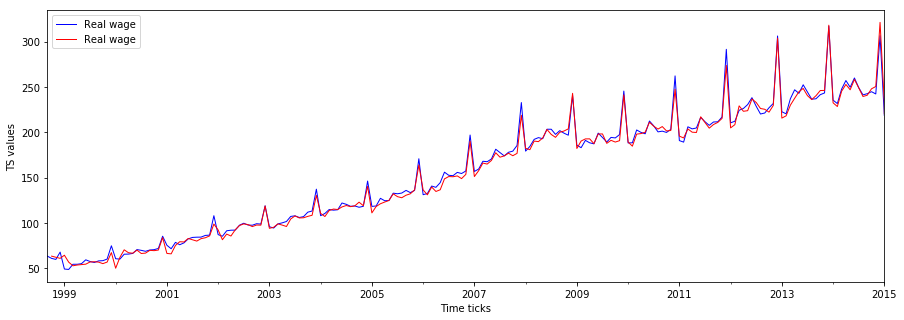

In [216]:
ts = ts1.loc['1998-09-01':]
# ES params
Params ={'alpha':0.5, 'delta': 0.95, 'seasonality_period': 12}
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts_f = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
# forecast
for cntr in ts.columns:
    x = ts[cntr]
    frc_ts_f[cntr] = WintersExponentialSmoothing(x, h, Params)

# show forecast alpha = 0.35
frc_ts_f.columns = ts.columns
ts_num = 0 

ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0)
frc_ts_f[frc_ts_f.columns[ts_num]].plot(c = "r", figsize=(15,5), linewidth=1.0)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [217]:
ix = range(len(ts.index))
qualityMAPE(ts.loc['2015-01-01':]['Real wage'], frc_ts_f.loc['2015-01-01':]['Real wage'])[0]

0.06520011195360026

<h2 align="left">4. Theil-Wage model for TS with linear trend and seasonality (25%)</h2>
You need to realize Theil-Wage model and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Theil-Wage model for (use code from seminar 2 as example)
* 2) Find optimal params $\alpha$ (smoothing of level), $\beta$ (smoothing trend) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$, $\beta$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model: is it better than the last one? 
* \*5) Suggest how can the Theil-Wage model be improved to make accuracy of forecast better?

In [194]:
def WageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    beta = Params['beta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= x[0]
    b = 0
    s= [0]* (p)

    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
            
            if math.isnan(s[cntr % p]):
                s[cntr % p] = s([(cntr-1)%p])
            l_old = l
            l = (l+b)*(1-alpha) + alpha*(x[cntr]-s[cntr % p])
            b = beta * (l-l_old) + (1-beta) * b
            s[cntr % p] = (1-delta)*s[cntr % p] + delta *(x[cntr]-l)
            
        FORECAST[cntr+h] = l+ b + s[(cntr+h)% p]
    return FORECAST

In [195]:
# Put your code here
ts = data
# Example: run forecast:
h = 1
rng = pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))

w_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
#  Quality = [np.NaN]*len(ts)
for cntr in ts.columns:
    w_frc_ts[cntr] = WageExponentialSmoothing(ts[cntr], h, {'alpha':0.3, 'delta': 0.95, 'beta': 0.1, 'seasonality_period': 12})

In [206]:
ts1 = data.loc['1998-09-01':'2015-01-01']

h = 1
params = [{'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.2},
        {'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.2},
        {'alpha':0.4, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.5, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.6, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.7, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.8, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.9, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.3, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.2, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.1, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.1}]
FRC_TS = dict()

for param in params:
    frc_ts = pd.DataFrame(index = ts1.index.append(pd.date_range(ts1.index[-1]+timedelta(1), ts1.index[-1]+timedelta(h)))
                          , columns = ts.columns)
    for cntr in ts.columns:
        frc_ts[cntr] = WintersExponentialSmoothing(ts1[cntr], h, param)
    FRC_TS[str(param)] = frc_ts

# compare ES parameters
QualityStr = pd.DataFrame(index = ts1.columns, columns = FRC_TS.keys())

ix = range(len(ts1.index))

for param_cntr in sorted(QualityStr.columns):
    frc_ts = FRC_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(ts1.iloc[ix], frc_ts.iloc[ix])

QualityStr.T

,Real wage
"{'alpha': 0.7, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.026949
"{'alpha': 0.8, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.027991
"{'alpha': 0.2, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.5}",0.038748
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.2, 'delta': 0.95}",0.030153
"{'alpha': 0.9, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.031033
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.5}",0.029898
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.95}",0.030153
"{'alpha': 0.1, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.5}",0.058596
"{'alpha': 0.4, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.026673
"{'alpha': 0.6, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.026157


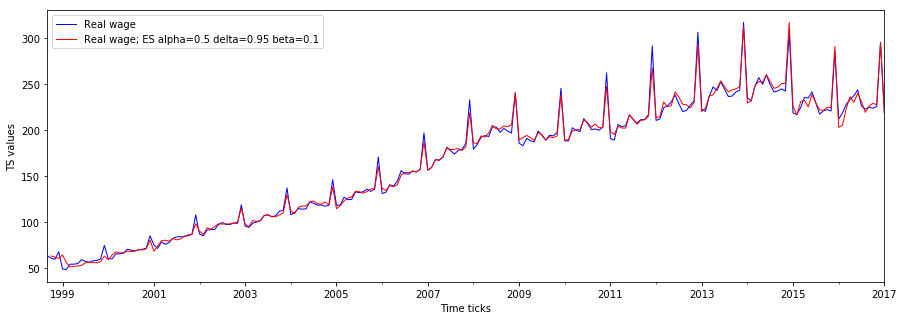

In [197]:
ts = data.loc['1998-09-01':]
# ES params
Params ={'alpha':0.5, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.1}
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts_f = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
# forecast
for cntr in ts.columns:
    x = ts[cntr]
    frc_ts_f[cntr] = WageExponentialSmoothing(x, h, Params)


frc_ts_f.columns = ts.columns+'; ES alpha=0.5 delta=0.95 beta=0.1'
ts_num = 0 

ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0)
frc_ts_f[frc_ts_f.columns[ts_num]].plot(c = "r", figsize=(15,5), linewidth=1.0)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [198]:
ix = range(len(ts.index))
qualityMAPE(ts.loc['2015-01-01':]['Real wage'], frc_ts_f.loc['2015-01-01':]['Real wage; ES alpha=0.5 delta=0.95 beta=0.1'])[0]

0.018671043013523344

We see a clear improvement here

<h2 align="left"> 5. Non-additive model of ES (25%)</h2>
You need to realize some ES-model that include non-addive component (or multiplicative trend or multiplicative component) and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize one of following ES models: ESM(A,M) (t.e. Holt-Winters model), ESM(Ad,M), ESM(M,A), ESM(M,M) model.
* 2) Find optimal params of the model (use data from 09.1998 to 01.2015). Note: if you choose damped trend model that $\phi$ you can just set it expetrly (say $0.98$). (Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values of it's params from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model and Theil-Wage model: is it better than the last one? 
* 5) Is it true that multiplicative model are more unstable than additive? Unstable means thet forecast is can diver

In [199]:
def MultiplicativeExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    beta = Params['beta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= x[0]
    r = 1
    s= [1]* (p)

    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
            
            if math.isnan(s[cntr % p]):
                s[cntr % p] = s([(cntr-1)%p])
            
            l_old = l
            l = (l*r)*(1-alpha) + alpha*(x[cntr]/s[cntr % p])
            r = beta * (l/l_old) + (1-beta) * r
            s[cntr % p] = (1-delta)*s[cntr % p] + delta *(x[cntr]/l)
            
        FORECAST[cntr+h] = l*r * s[(cntr+h)% p]
    return FORECAST

In [201]:
# Put your code here
ts = data
# Example: run forecast:
h = 1
rng = pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))

w_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
#  Quality = [np.NaN]*len(ts)
for cntr in ts.columns:
    w_frc_ts[cntr] = MultiplicativeExponentialSmoothing(ts[cntr], h, {'alpha':0.3, 'delta': 0.95, 'beta': 0.1, 'seasonality_period': 12})

In [203]:
ts1 = data.loc['1998-09-01':'2015-01-01']

h = 1
params = [{'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.2},
        {'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.3},
        {'alpha':0.3, 'delta': 0.95, 'seasonality_period': 12, 'beta': 0.4},
        {'alpha':0.3, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.2, 'delta': 0.9, 'seasonality_period': 12, 'beta': 0.1},
        {'alpha':0.3, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.3},
        {'alpha':0.05, 'delta': 0.5, 'seasonality_period': 12, 'beta': 0.9},]
FRC_TS = dict()

for param in params:
    frc_ts = pd.DataFrame(index = ts1.index.append(pd.date_range(ts1.index[-1]+timedelta(1), ts1.index[-1]+timedelta(h)))
                          , columns = ts.columns)
    for cntr in ts.columns:
        frc_ts[cntr] = MultiplicativeExponentialSmoothing(ts1[cntr], h, param)
    FRC_TS[str(param)] = frc_ts

# compare ES parameters
QualityStr = pd.DataFrame(index = ts1.columns, columns = FRC_TS.keys())

ix = range(len(ts1.index))

for param_cntr in sorted(QualityStr.columns):
    frc_ts = FRC_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(ts1.iloc[ix], frc_ts.iloc[ix])

QualityStr.T

,Real wage
"{'alpha': 0.05, 'seasonality_period': 12, 'beta': 0.9, 'delta': 0.5}",0.058515
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.5}",0.023306
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.4, 'delta': 0.95}",0.091392
"{'alpha': 0.2, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.9}",0.027827
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.3, 'delta': 0.95}",0.034574
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.1, 'delta': 0.95}",0.024287
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.3, 'delta': 0.5}",0.026161
"{'alpha': 0.3, 'seasonality_period': 12, 'beta': 0.2, 'delta': 0.95}",0.027011


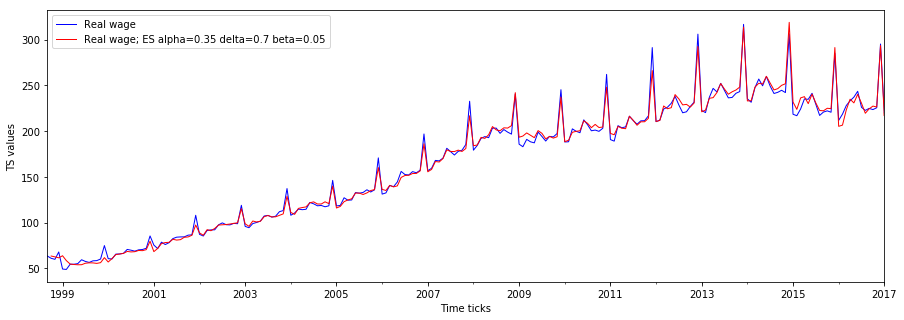

In [204]:
ts = data.loc['1998-09-01':]
# ES params
Params ={'alpha':0.35, 'delta': 0.7, 'seasonality_period': 12, 'beta': 0.05}
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts_f = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
# forecast
for cntr in ts.columns:
    x = ts[cntr]
    frc_ts_f[cntr] = WageExponentialSmoothing(x, h, Params)

# show forecast alpha = 0.35
frc_ts_f.columns = ts.columns+'; ES alpha=0.35 delta=0.7 beta=0.05'
ts_num = 0 

ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0)
frc_ts_f[frc_ts_f.columns[ts_num]].plot(c = "r", figsize=(15,5), linewidth=1.0)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [205]:
ix = range(len(ts.index))
qualityMAPE(ts.loc['2015-01-01':]['Real wage'], frc_ts_f.loc['2015-01-01':]['Real wage; ES alpha=0.35 delta=0.7 beta=0.05'])[0]

0.020222410714731104

Clearly the best algorithm in this case is  **MultiplicativeExponentialSmoothing**